# Обучение собсвенной сети по распознаванию лиц на основе RESNET как генератора вектора

Создадим датасет и разобьем на трейн и тест (часть людей на трейн и часть людей на тест при этом чтоб подмножества людей не пересекались)

In [69]:
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm

from TransformDataset import TripletDataset, LFWFacesDataset

# Преобразования для тренировочных и валидационных данных
train_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#Применяется для исходного изображения 
val_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(), # Преобразование изображения в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Создаем объекты класса датасета для тренировочных и валидационных данных
train_dataset = LFWFacesDataset('../FakeDataset/train',  train=True)
val_dataset = LFWFacesDataset('../FakeDataset/test', train=False)


In [14]:
print(len(train_dataset))

892


Даталоадер, формирующий каждый раз триплет:

In [88]:
import torch
from torch.utils.data import DataLoader



train_triplet_dataset = TripletDataset(train_dataset, transform=train_transform)
val_triplet_dataset = TripletDataset(val_dataset, transform=val_transform)

train_loader = DataLoader(train_triplet_dataset, batch_size=32,  shuffle=True)
val_loader = DataLoader(val_triplet_dataset, batch_size=32, shuffle=False)


Пример с трейнового набора:

In [16]:
print(len(train_loader))

28


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


torch.Size([32, 3, 300, 300])
torch.Size([32, 3, 300, 300])
torch.Size([32, 3, 300, 300])


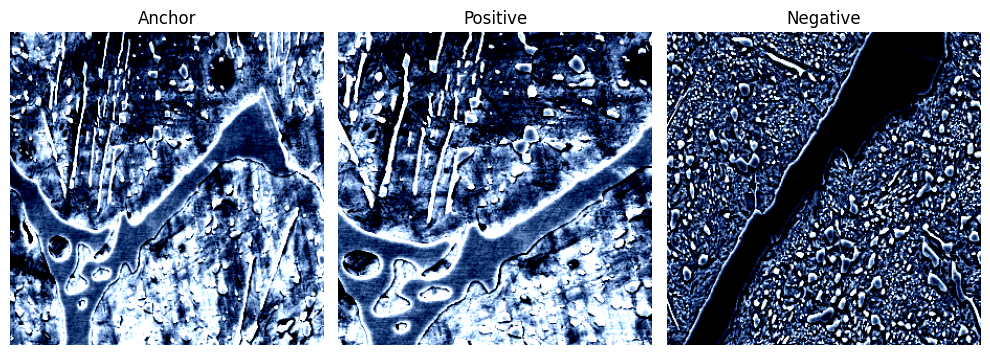

In [43]:
# Генерируем один триплет
anchors, positives, negatives = next(iter(train_loader))
print(anchors.shape)
print(positives.shape)
print(negatives.shape)
# Визуализируем триплет в subplot
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Преобразуем тензоры обратно в NumPy массивы для визуализации
anchors_np = anchors.permute(0, 2, 3, 1).numpy()
positives_np = positives.permute(0, 2, 3, 1).numpy()
negatives_np = negatives.permute(0, 2, 3, 1).numpy()

# Визуализируем три изображения
axs[0].imshow(anchors_np[0])
axs[0].set_title('Anchor')
axs[1].imshow(positives_np[0])
axs[1].set_title('Positive')
axs[2].imshow(negatives_np[0])
axs[2].set_title('Negative')

# Удаляем оси для всех изображений
for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

Пример с валидационного набора:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7240347..1.3328106].


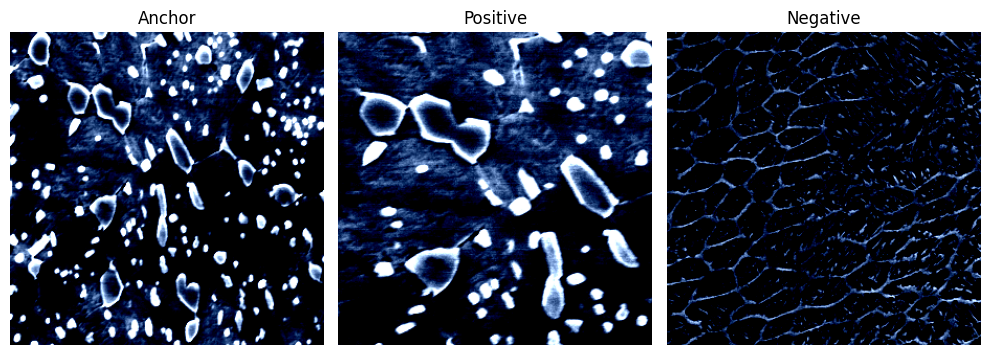

In [89]:
# Генерируем один триплет
anchors, positives, negatives = next(iter(val_loader))

# Визуализируем триплет в subplot
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Преобразуем тензоры обратно в NumPy массивы для визуализации
anchors_np = anchors.permute(0, 2, 3, 1).numpy()
positives_np = positives.permute(0, 2, 3, 1).numpy()
negatives_np = negatives.permute(0, 2, 3, 1).numpy()

# Визуализируем три изображения
axs[0].imshow(anchors_np[0])
axs[0].set_title('Anchor')
axs[1].imshow(positives_np[0])
axs[1].set_title('Positive')
axs[2].imshow(negatives_np[0])
axs[2].set_title('Negative')

# Удаляем оси для всех изображений
for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [90]:

def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for batch_idx, (anchors, positives, negatives) in tqdm(enumerate(train_loader)):
        anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)
        optimizer.zero_grad()
        anchor_embeddings = model(anchors)
        positive_embeddings = model(positives)
        negative_embeddings = model(negatives)
        loss = criterion(anchor_embeddings, positive_embeddings, negative_embeddings)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #print(loss.item())
       
    avg_loss = running_loss / len(train_loader)
    print(f'Train Epoch: \tLoss: {avg_loss:.6f}')
    return avg_loss


# Определение функции для оценки потерь на валидационном наборе
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch_idx, (anchors, positives, negatives) in tqdm(enumerate(val_loader)):
            anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)
            anchor_embeddings = model(anchors)
            positive_embeddings = model(positives)
            negative_embeddings = model(negatives)
            loss = criterion(anchor_embeddings, positive_embeddings, negative_embeddings)
            running_loss += loss.item()
            torch.cuda.empty_cache()
            #print(loss.item())
    avg_loss = running_loss / len(val_loader)
    print(f'Val Epoch: \tLoss: {avg_loss:.6f}')
    return avg_loss

Создание архитектуры:

In [85]:
from models.ModifiedInceptionResnetV1 import ModifiedInceptionResnetV1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "model_weights3.pt"
model = ModifiedInceptionResnetV1(device=device)
model.load_state_dict(torch.load(model_path))

for name, param in model.named_parameters():
    #name.startswith('last') or name.startswith('block8')
    if  name.startswith('logits') or name.startswith('last') : 
        param.requires_grad = True
    else:
        param.requires_grad = False



In [86]:
# Лосс функция
loss_fn = torch.nn.TripletMarginLoss(margin=0.2, p=2.0, eps=1e-06)
# Оптимизатор
optimizer = optim.Adam(model.parameters(), lr=0.005)

Обучение сети:

----------------
Epoch 1/10 training:


28it [00:39,  1.41s/it]


Train Epoch: 	Loss: 0.007743


8it [00:10,  1.25s/it]


Val Epoch: 	Loss: 0.004654
----------------
Epoch 2/10 training:


28it [00:40,  1.45s/it]


Train Epoch: 	Loss: 0.009435


8it [00:10,  1.25s/it]


Val Epoch: 	Loss: 0.005042
----------------
Epoch 3/10 training:


28it [00:40,  1.46s/it]


Train Epoch: 	Loss: 0.008159


8it [00:10,  1.28s/it]


Val Epoch: 	Loss: 0.010992
----------------
Epoch 4/10 training:


28it [00:41,  1.47s/it]


Train Epoch: 	Loss: 0.007248


8it [00:10,  1.31s/it]


Val Epoch: 	Loss: 0.004470
----------------
Epoch 5/10 training:


28it [00:41,  1.49s/it]


Train Epoch: 	Loss: 0.007832


8it [00:10,  1.32s/it]


Val Epoch: 	Loss: 0.009430
----------------
Epoch 6/10 training:


28it [00:41,  1.48s/it]


Train Epoch: 	Loss: 0.005830


8it [00:10,  1.28s/it]


Val Epoch: 	Loss: 0.012901
----------------
Epoch 7/10 training:


28it [00:41,  1.47s/it]


Train Epoch: 	Loss: 0.007487


8it [00:10,  1.29s/it]


Val Epoch: 	Loss: 0.005684
----------------
Epoch 8/10 training:


28it [00:41,  1.49s/it]


Train Epoch: 	Loss: 0.007893


8it [00:10,  1.34s/it]


Val Epoch: 	Loss: 0.005502
----------------
Epoch 9/10 training:


28it [00:41,  1.50s/it]


Train Epoch: 	Loss: 0.006180


8it [00:10,  1.27s/it]


Val Epoch: 	Loss: 0.003652
----------------
Epoch 10/10 training:


28it [00:41,  1.47s/it]


Train Epoch: 	Loss: 0.008072


8it [00:10,  1.28s/it]


Val Epoch: 	Loss: 0.006880


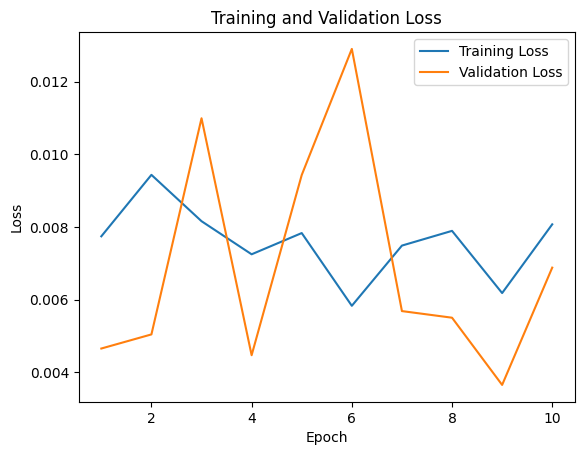

In [91]:

num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    print("----------------")
    print(f"Epoch {epoch+1}/{num_epochs} training:")
    train_loss = train_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss = validate_epoch(model, val_loader, loss_fn, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# # Построение графиков
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Сохранение итога:

In [92]:


model.eval()
# Сохранение весов модели в формате .pth
torch.save(model.state_dict(), 'model_weights4.pt')

